In [1]:
from pathlib import Path

import numpy as np
import tqdm
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt

In [2]:
class Sigma:

    def __init__(self, gf0, gf, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,gf.n,gf.n), complex)
        for e, energy in enumerate(tqdm.tqdm(energies)):
            sigma[e] = np.linalg.inv(g0[...,e]) - np.linalg.inv(g[...,e])
        return sigma


In [3]:
path = Path('../output/lowdin/')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]
occupancy_goal = np.load("../output/lowdin/occupancy/occupancies_gfp.npy")
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 6e-2
z = energies + eta*1.j
beta = 1000.
# beta = 70.
params['z'] = occupancy_goal
V = np.loadtxt('../output/lowdin/U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))
# neig = get_active_neig(nimp, [(nimp//2,nimp//2)], 3)
neig = np.ones((nimp+1)*(nimp+1),int) * 4

In [4]:
np.diag(DC)

array([5.7811579 , 2.54748617, 2.27502273, 2.25033648, 2.44118583,
       2.83134256, 2.34763135, 2.62004357, 6.20584808])

In [5]:
eigvals, _ = np.linalg.eigh(H_eff-DC)
eigvals

array([-11.30677751, -11.00365579,  -7.82440579,  -5.70687795,
        -4.95025701,  -2.553914  ,   0.31158343,   1.08915029,
         4.51903883])

In [6]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
# TODO Look at implementing build_gf_lanczos here instead of build_gf2_lanczos
DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


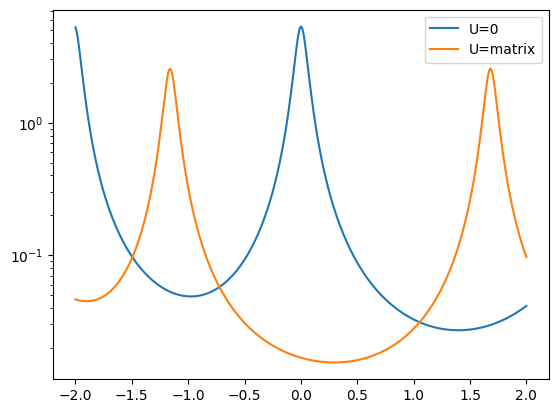

In [7]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U=matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [38]:
espace.keys()

dict_keys([(5, 6), (6, 5)])

In [36]:
egs

-71.8929777384291

In [8]:
# sigma = Sigma(gf0, gf, eta=eta)
# sig = sigma.retarded(energies)
# np.save('../output/lowdin/ed/ed_sigma.npy', sig)
sig = np.load('../output/lowdin/ed/ed_sigma.npy')
sig_trace = np.trace(sig,axis1=1,axis2=2)

In [11]:
sig.shape

(401, 9, 9)

In [9]:
ref_sig_uii_trace = np.loadtxt('../reference/sigma_ed_uii_trace.txt')
ref_sig_ed_trace = np.loadtxt('../reference/sigma_ed_trace.txt')


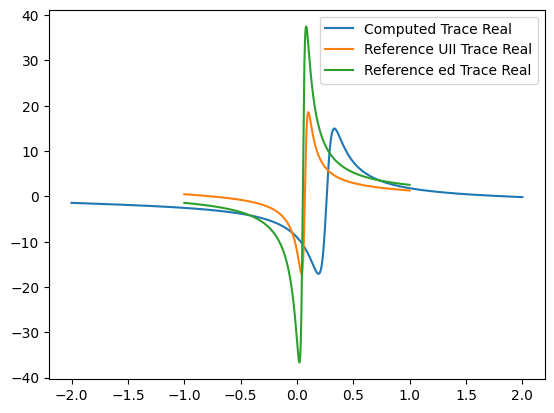

Real part peak positions (computed): [0.33]
Real part dip positions (computed): [0.19]
Real part peak positions (reference): [0.101]
Real part dip positions (reference): [0.041]


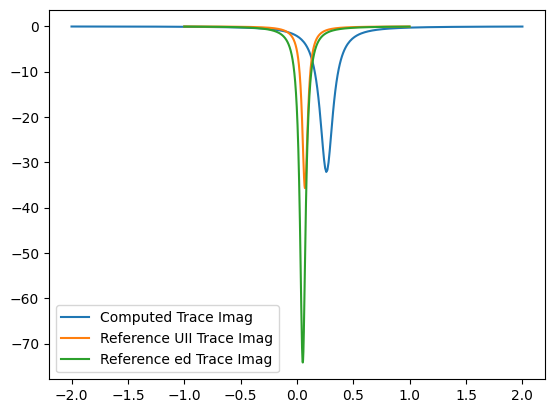

Imaginary part peak positions (computed): []
Imaginary part dip positions (computed): [0.26]
Imaginary part peak positions (reference): []
Imaginary part dip positions (reference): [0.071]


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

ref_sig_uii_trace = np.loadtxt('../reference/sigma_ed_uii_trace.txt')
ref_sig_ed_trace = np.loadtxt('../reference/sigma_ed_trace.txt')

# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 1], label="Reference UII Trace Real")
plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 1], label="Reference ed Trace Real")
plt.legend()
plt.show()

# Find and print peaks and dips for the real part of the computed trace
real_peaks, _ = find_peaks(sig_trace.real)
real_dips, _ = find_peaks(-sig_trace.real)
real_peak_positions = energies[real_peaks]
real_dip_positions = energies[real_dips]
print("Real part peak positions (computed):", real_peak_positions)
print("Real part dip positions (computed):", real_dip_positions)

# Find and print peaks and dips for the real part of the reference trace
ref_real_peaks, _ = find_peaks(ref_sig_uii_trace[:, 1])
ref_real_dips, _ = find_peaks(-ref_sig_uii_trace[:, 1])
ref_real_peak_positions = ref_sig_uii_trace[ref_real_peaks, 0]
ref_real_dip_positions = ref_sig_uii_trace[ref_real_dips, 0]
print("Real part peak positions (reference):", ref_real_peak_positions)
print("Real part dip positions (reference):", ref_real_dip_positions)

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 2], label="Reference UII Trace Imag")
plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 2], label="Reference ed Trace Imag")
plt.legend()
plt.show()

# Find and print peaks and dips for the imaginary part of the computed trace
imag_peaks, _ = find_peaks(sig_trace.imag)
imag_dips, _ = find_peaks(-sig_trace.imag)
imag_peak_positions = energies[imag_peaks]
imag_dip_positions = energies[imag_dips]
print("Imaginary part peak positions (computed):", imag_peak_positions)
print("Imaginary part dip positions (computed):", imag_dip_positions)

# Find and print peaks and dips for the imaginary part of the reference trace
ref_imag_peaks, _ = find_peaks(ref_sig_uii_trace[:, 2])
ref_imag_dips, _ = find_peaks(-ref_sig_uii_trace[:, 2])
ref_imag_peak_positions = ref_sig_uii_trace[ref_imag_peaks, 0]
ref_imag_dip_positions = ref_sig_uii_trace[ref_imag_dips, 0]
print("Imaginary part peak positions (reference):", ref_imag_peak_positions)
print("Imaginary part dip positions (reference):", ref_imag_dip_positions)


In [32]:
index = np.argmin(np.abs(energies - 0.071))
index

207

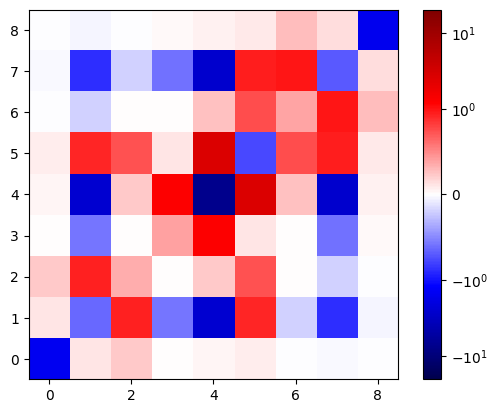

In [33]:
import matplotlib.colors as mcolors

plt.imshow(sig[index].real, cmap='seismic', origin='lower',norm=mcolors.SymLogNorm(linthresh=1, vmin=-20, vmax=20))
plt.colorbar()
